# Problème inverse : Assignation de données

On considère l'équation de la chaleur stationnaire avec terme source dans un domaine $\Omega = [0 , L] \times [0 , H]$ :

$$
\left\{
    \begin{array}{ll}
        \Delta u = f & \text{dans } \Omega \\
        u = 0 & \text{sur } \partial \Omega
    \end{array}
\right.
$$
    
et alors
$(u, f) \in V = \left\{ u \in H^1_0(\Omega), f \in L^2(\Omega) \; \big\lvert \; \Delta u = f \right\}.$
    
On considère $N$ points $(x_i, y_i) \in \Omega$ où la température $T_i$ est fixée (mesurée).

On cherche à minimiser la quantité:

$$
I = \sum_{i=1}^N \left( u(x_i, y_i) - T_i \right)^2
$$

sur $(u, f) \in V$ pour reconstruire la solution $u$ à partir des $T_i$.

# Equation de la chaleur par différences finies 2D

Dans un premier temps, il faut simuler l'équation de la chaleur stationnaire 2D par différences finies sur une grille cartésienne afin de se pouvoir calculer $T_i$.

On se donne le maillage suivant:

![Maillage en espace ($(i,j) \in [0,n_x + 1] \times [0,n_y + 1]$ et $[x_0,x_{n_x + 1}] \times [y_0,y_{n_y + 1}] = [0;L_x] \times [0;L_y]$)](mesh.png)

Maillage en espace ($(i,j) \in [0,n_x + 1] \times [0,n_y + 1]$ et $[x_0,x_{n_x + 1}] \times [y_0,y_{n_y + 1}] = [0;L_x] \times [0;L_y]$)

On approche l'équation $\Delta u = f$ par le schéma suivant:

$$
\frac{2 u_{i,j} - u_{i+1,j} - u_{i-1,j}}{\Delta x^2} + \frac{2 u_{i,j} - u_{i,j+1} - u_{i,j-1}}{\Delta y^2} = f_{i,j}
$$

Afin de pouvoir écrire ce schéma sous forme matricielle on va changer la numérotation des indices en posant 

$k = i - 1 + n_x (j-1)$, soit $u_{k} = u_{i,j}$.

On retombe sur $i$ et $j$ avec $i = k \% n_x  + 1$ et $j = (k - i + 1) // n_x + 1$ (le reste et la partie entière de $k$ par $n_x$).On obtient donc le nouveau schéma:

$$
    \frac{2 u_{k} - u_{k+1} - u_{k-1}}{\Delta x^2} + \frac{2 u_{k} - u_{k+n_x} - u_{k-n_x}}{\Delta y^2} = f_{k}
$$

On peux donc écrire le schéma sous forme matricielle (sans considérer les bords):

$$
    A U = b
$$

où $U = (u_{k})_{k \in I}$ ($I = [0, n_x n_y - 1]$), $b = (f_{k})_{k \in I}$ et la matrice $A = a_{kl}$ la matrice du laplacien 2D:

$$
a_{kl} =
\begin{cases}
\frac{2}{\Delta x^2} + \frac{2}{\Delta y^2}, & \text{si } k = l \\
\frac{-1}{\Delta x^2}, & \text{si } i = j - 1 \text{ ou } k = l + 1\\
\frac{-1}{\Delta y^2}, & \text{si } i = j - n_x \text{ ou } k = l + n_x\\
0, & \text{sinon}
\end{cases}
$$


## Solveur utilisé : Gradient Conjugué

### Algo:

$k = 0$,\
$r_k = b - A x_0$,\
$p=r_k$

**Tant que** ($ \|r_k\| > \epsilon$) et ($k \leq k_{max}$)  **faire**

$z = Ap$,\
$\alpha = \frac{<r_k,r_k>}{<z,p>}$,\
$x=x-\alpha p$,\
$r_{k+1} = r_k - \alpha z$,\
$\gamma = \frac{<r_{k+1},r_{k+1}>}{<r_{k}, r_{k}>}$,\
$p = r_{k+1} + \gamma p$,\
$k=k+1$,

**Fin Tant Que**

**Retourner** k, x

# Fonction *heat* pour simuler l'équation de la chaleur stationnaire

In [3]:
import numpy  as np
import time
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags

def heat(nx, ny, u0, f, L=1, H=1, max_iter=10000, epsilon=1e-7):
    """ Fonction simulant l'équation de la chaleur stationnaire 2D sur un maillage cartésien uniforme par différences finies
    avec des conditions aux limites de type Dirichlet homogène. Arguments :
        - nx : nombre de mailles selon x
        - ny : nombre de mailles selon y
        - u0 : solution initiale (scalaire)
        - f : terme source (fonction prenant 2 scalaires (x, y) en entrée pour retourner un scalaire f(x, y))
        - L : longueur du domaine (= 1 par défaut)
        - H : hauteur du domaine (= 1 par défaut)
        - max_iter : nombre maximal d'itérations pour le gradient conjugué (= 10000 par défaut)
        - epsilon : seuil d'erreur minimal pour le gradient conjugué (= 1e-7 par défaut) """

       # Construction du maillage : liste P des points P(i,j) = (x(i), y(j)) 
    # du maillage indexés par k = i - 1 + nx * (j - 1)
    N = nx * ny
    dx = L / (nx+1)
    dy = H / (ny+1)
    P = np.array([[[i * dx, j * dy] for i in range(1, nx + 1)] for j in range(1, ny + 1)]) 
    P = P.reshape(N, 2)

    # Construction du système linéaire Au = b
    
    N = nx * ny
    alpha = 2 * (1 / dx**2 + 1 / dy**2) * np.ones(N) # Diagonale de A
    beta = - np.ones(N - 1) / dx ** 2 # Diagonales décalées de 1 indice
    beta[nx - 1::nx] = 0 # Brisures de la diagonale
    gamma = - np.ones(N - nx) / dy ** 2 # Diagonale décalée de nx indices
    k = [gamma, beta, alpha, beta, gamma]
    offset = [-nx, -1, 0, 1, nx]
    A = diags(k, offset).toarray() # Matrice A
    b = np.array([f(P[k, 0], P[k, 1]) for k in range(N)]) # Second membre b

    # Résolution du système linéaire
    
    u = u0 * np.ones(N) 
    rk = b - np.dot(A,u)
    p = rk
    k = 0
    kmax = max_iter

    while np.linalg.norm(rk) > epsilon and k < kmax:
        z = np.dot(A, p)
        alpha = np.dot(rk,p) / np.dot(z, p)
        u = u - alpha * p
        rkp1 = rk - alpha * z
        gamma =  np.dot(rkp1,rkp1) / np.dot(rk,rk)
        p = rkp1 + gamma * p
        rk = rkp1
        k += 1
        
    print("Nombre d'itérations du gradient conjugué: ", k)
    print("Résidu du gradient conjugué: ", np.linalg.norm(rk))

    u2D = u.reshape(Nx, Ny)
    u = np.zeros((Nx+2, Ny+2))
    u[1:-1, 1:-1] = u2D

    
    return u, A, b, u2D

# Test de la fonction *heat*

Nombre d'itérations du gradient conjugué:  459
Résidu du gradient conjugué:  9.56436067273877e-08


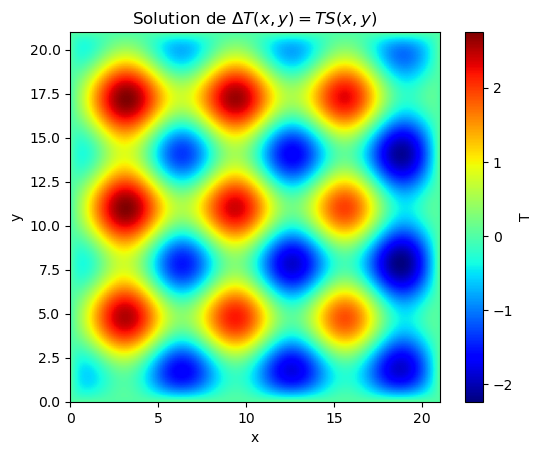

In [4]:
# Définition du terme source

def TS(x,y):
    
    return np.cos(x) + np.sin(y)

# Définition des paramètres

Nx = 150
Ny = 150
H = 21
L = 21

# Résolution du problème

T = heat(Nx, Ny, 0, TS, H=H, L=L)[0]

# Affichage du résultat

plt.imshow(T, origin='lower', cmap='jet', extent=[0, L, 0, H])
cbar = plt.colorbar() 
cbar.set_label('T')

plt.xlabel('x')  # Légende de l'axe X
plt.ylabel('y')  # Légende de l'axe Y
plt.title(r'Solution de $\Delta T(x,y) = TS(x,y)$')  # Titre du graphique

plt.show()


# Vérification 

On choisit ici la solution pour la solution exacte :

$$
u_{exact}(x,y) = \frac{1}{LH} x \cdot y \cdot (L - x) \cdot (H - y)
$$

qui respecte bien les conditions de dirichlet imposées aux bords.

On calcul le terme source associé $f_{exact} = \frac{\partial^2 u_{exact}}{\partial x^2} + \frac{\partial^2 u_{exact}}{\partial y^2}$ :

$$
u_{exact}(x,y) =\frac{1}{LH}(LHxy - Hx^2y - Lxy^2 + x^2 y^2)
$$

On en déduit donc :

$$
f_{exact}(x,y) = \frac{1}{LH} (- 2Hy + 2y^2 - 2Lx + 2x^2)
$$

Nombre d'itérations du gradient conjugué:  268
Résidu du gradient conjugué:  9.150473446821239e-08


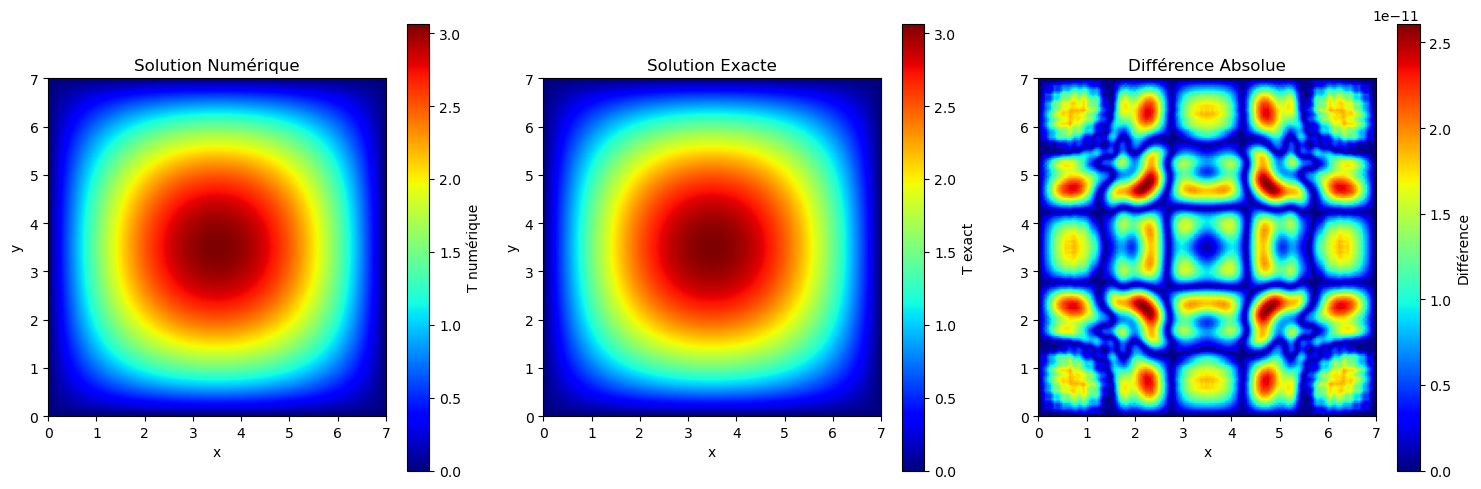

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Définition des paramètres

Nx = 150
Ny = 150
H = 7
L = 7

# Définition du terme source

def TS(x,y):
    
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème

T = heat(Nx, Ny, 0, TS, H=H, L=L, epsilon=1e-7)[0]

# Vérification

def u_exact(x,y):
    
    return x*y*(L-x)*(H-y) / (L * H)

# Calcul de la solution exacte
X, Y = np.meshgrid(np.linspace(0, L, Nx+2), np.linspace(0, H, Ny+2))
U_exact = u_exact(X, Y)

# Calcul de la différence
diff = np.abs(T - U_exact)

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5)) # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 1)
plt.imshow(T, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution exacte
plt.subplot(1, 3, 2)
plt.imshow(U_exact, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='T exact')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Exacte')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff, origin='lower', cmap='jet', extent=[0, L, 0, H])
plt.colorbar(label='Différence')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue')

plt.tight_layout()
plt.show()

# Equation des sensibilités

Nombre d'itérations du gradient conjugué:  178
Résidu du gradient conjugué:  8.958498629696441e-08
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0047088  0.00932343 ... 0.00932343 0.0047088  0.        ]
 [0.         0.00932343 0.01846039 ... 0.01846039 0.00932343 0.        ]
 ...
 [0.         0.00932343 0.01846039 ... 0.01846039 0.00932343 0.        ]
 [0.         0.0047088  0.00932343 ... 0.00932343 0.0047088  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


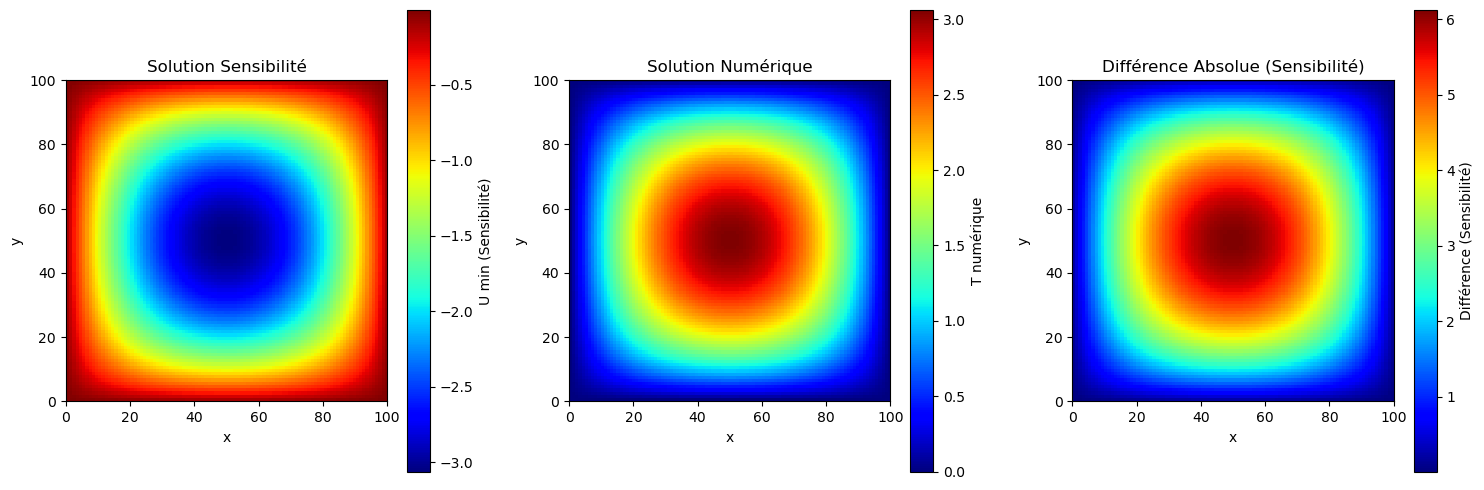

In [13]:
import numpy  as np
import time
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags

# Définition des paramètres

Nx = 100
Ny = 100
H = 7
L = 7

# Définition du terme source

def TS(x,y):
    
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème
H = heat(Nx, Ny, 0, TS, H=H, L=L, epsilon=1e-7)

T = H[3]
A = H[1]
F = H[2]
Q = H[0]
print(Q)
# Fonction de sensibilité pour le minimum
def SensitivityMethod(T, A, F):
    # Calcul de la sensibilité
    S = A.transpose().dot(np.linalg.inv(A.dot(A.transpose())))

    # Calcul du gradient de la fonction coût
    grad_J = A.dot(T.flatten()) - F

    # Calcul de la direction de descente
    d = -S.dot(grad_J)

    # Mise à jour de la solution
    U = T.flatten() + d
    U = U.reshape(T.shape)

    return U

# Solution par la méthode de sensibilité pour le minimum
U_sensitivity = SensitivityMethod(T, A, F)

# Calcul de la différence
diff_sensitivity = np.abs(U_sensitivity - T)

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5))  # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 2)
plt.imshow(Q, origin='lower', cmap='jet', extent=[0, len(T[0]), 0, len(T)])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution de la méthode de sensibilité
plt.subplot(1, 3, 1)
plt.imshow(U_sensitivity, origin='lower', cmap='jet', extent=[0, len(U_sensitivity[0]), 0, len(U_sensitivity)])
plt.colorbar(label='U min (Sensibilité)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Sensibilité')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff_sensitivity, origin='lower', cmap='jet', extent=[0, len(diff_sensitivity[0]), 0, len(diff_sensitivity)])
plt.colorbar(label='Différence (Sensibilité)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue (Sensibilité)')

plt.tight_layout()
plt.show()


# Equation adjointes

# Gradient projeté

Nombre d'itérations du gradient conjugué:  178
Résidu du gradient conjugué:  8.958498629696441e-08
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0047088  0.00932343 ... 0.00932343 0.0047088  0.        ]
 [0.         0.00932343 0.01846039 ... 0.01846039 0.00932343 0.        ]
 ...
 [0.         0.00932343 0.01846039 ... 0.01846039 0.00932343 0.        ]
 [0.         0.0047088  0.00932343 ... 0.00932343 0.0047088  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


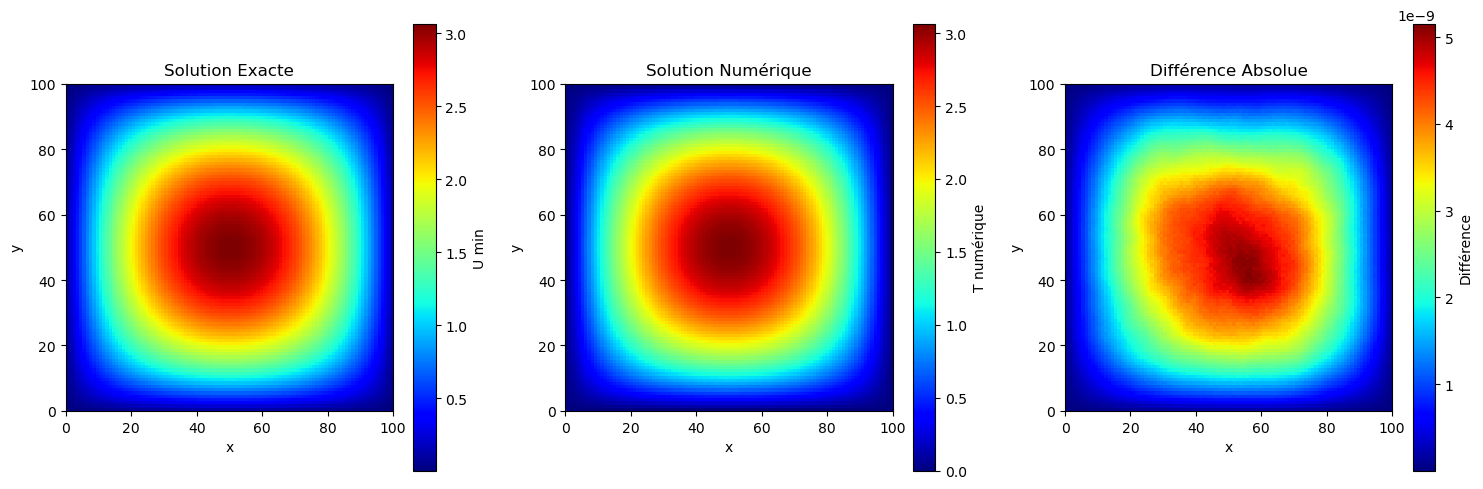

In [6]:

import numpy  as np
import time
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags

# Définition des paramètres

Nx = 100
Ny = 100
H = 7
L = 7

# Définition du terme source

def TS(x,y):
    
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème
H = heat(Nx, Ny, 0, TS, H=H, L=L, epsilon=1e-7)

T = H[3]
A = H[1]
F = H[2]
Q = H[0]

# Fonction gradient projeté
print(Q)
def GradientProj(T, A, F):
    r = A.dot(T.flatten())
    c = r - F
    e = A.dot(A.transpose())
    g = np.linalg.inv(e).dot(c)
    U = T.flatten() - A.transpose().dot(g)
    U = U.reshape(T.shape)
    
    return U

# solution par le gradient projeté

U = -GradientProj(T, A, F)

# Calcul de la différence
diff = np.abs(U - T)

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5)) # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 2)
plt.imshow(Q, origin='lower', cmap='jet', extent=[0, len(T[0]), 0, len(T)])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution du gradient projeté
plt.subplot(1, 3, 1)
plt.imshow(U, origin='lower', cmap='jet', extent=[0, len(U[0]), 0, len(U)])
plt.colorbar(label='U min')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Exacte')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff, origin='lower', cmap='jet', extent=[0, len(diff[0]), 0, len(diff)])
plt.colorbar(label='Différence')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue')

plt.tight_layout()
plt.show()

# Algorithme d'Uzawa